Transfer learning DeiT to CIFAR-10

In [61]:
from transformers import DeiTForImageClassification, AutoImageProcessor
import torch
import torch.nn as nn
from datasets import load_dataset
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
dataset = load_dataset("CIFAR10")

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


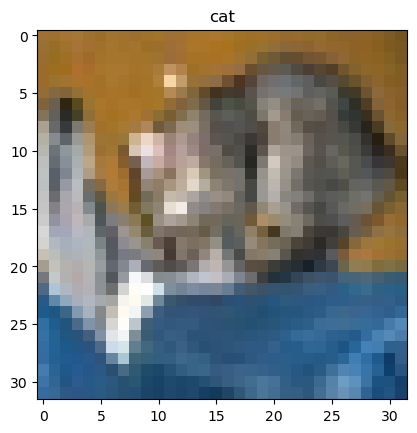

In [63]:
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", attn_implementation="sdpa", torch_dtype=torch.float16)

id_to_lb = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

image_test = dataset["test"][0]
plt.imshow(image_test["img"])
plt.title(id_to_lb[image_test["label"]])
plt.show()

In [70]:
image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

class Dataloader:
    def __init__(self, dataset, image_processor, B):
        self.B = B
        self.dataset = dataset
        self.image_processor = image_processor
        self.current_idx = 0

    def shuffle(self):
        self.dataset = self.dataset.shuffle()

    def get_batch(self):
        images = self.dataset["img"][self.current_idx:self.current_idx+self.B]
        labels = self.dataset["label"][self.current_idx:self.current_idx+self.B]
        images = self.image_processor(images, return_tensors="pt")
        labels = torch.tensor(labels).to(device)
        self.current_idx += self.B
        if self.current_idx >= len(self.dataset["img"]):
            self.current_idx = 0
            self.shuffle()
        return images, labels

In [72]:
dl = Dataloader(dataset["train"], image_processor, B=32)

model.classifier = nn.Linear(model.config.hidden_size, 10)
model.to(device)

for iter in range(100):
    images, labels = dl.get_batch()
    print(type(images))
    break
    # outputs = model(images, labels=labels)
    # loss = outputs.loss
    # loss.backward()
    # optimizer.step()
    # optimizer.zero_grad()
    # print(f"iter: {iter}, loss: {loss.item()}")

<class 'transformers.image_processing_base.BatchFeature'>
